In [ ]:
import numpy as np
import pandas as pd
from sublimpy import utils, tidy
import altair as alt
alt.data_transformers.enable('json')
from scipy import interpolate

import swifter
import xarray as xr
import tqdm
import matplotlib.pyplot as plt
from metpy.units import units

import datetime as dt
from sklearn.metrics import r2_score
from metpy.units import units
import math 
import geopandas as gpd

In [ ]:
HEIGHTS = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20

data_start_date = '20221129 2330'
data_cutoff_date = '20230509 0000'

## PARAMETERS FOR SOS DATA
# streamwise coordinates
sos_tidy_fn = f"process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10.parquet"
sos_tidy_fn_single_pf = f"process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_archive.parquet"

## PARAMETERS FOR SPLASH DATA
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

# Open data

## SOS

In [ ]:
tidy_df = pd.read_parquet(sos_tidy_fn)
# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df[tidy_df.time > data_start_date][tidy_df.time < data_cutoff_date]
tidy_df = tidy_df.set_index('time').sort_index().loc[data_start_date:data_cutoff_date].reset_index()

tidy_df_single_pf = pd.read_parquet(sos_tidy_fn_single_pf)
# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df_single_pf['time'] = pd.to_datetime(tidy_df_single_pf['time'])
tidy_df_single_pf = utils.modify_df_timezone(tidy_df_single_pf, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df_single_pf = tidy_df_single_pf[tidy_df_single_pf.time > data_start_date][tidy_df_single_pf.time < data_cutoff_date]
tidy_df_single_pf = tidy_df_single_pf.set_index('time').sort_index().loc[data_start_date:data_cutoff_date].reset_index()

In [ ]:
tidy_df.time.min(), tidy_df.time.max()

In [ ]:
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230301':'20230401']))
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230301':'20230401'].dropna()))

In [ ]:
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230401':'20230501']))
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230401':'20230501'].dropna()))

In [ ]:
src = tidy_df.query(f"variable == 'dir_3m_c'")['value'].dropna()
pd.cut(
    src,
    [0,80, 140, 292,332, 360]
).value_counts() / len(src)

## SPLASH

In [ ]:

# Get the list of files in the directory
file_list = os.listdir(kps_download_dir)

# file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]
file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]

# Sort the file list
file_list.sort()

# Create an empty list to store the dataarrays
mixingratio_dataarray_list = []
abshum_dataarray_list = []
snowdepth_list = []
temp_dataarray_list = []
rh_dataarray_list = []
w_dataarray_list = []

# Iterate over each file with tqdm
for file_name in tqdm.tqdm(file_list):
    # Open the file using xarray
    dataset = xr.open_dataset(os.path.join(kps_download_dir, file_name))
    
    # Extract the dataarray for the variable 'mixing_ratio', Add the dataarray to the list
    mixingratio_dataarray_list.append(dataset['mixing_ratio'])
    abshum_dataarray_list.append(dataset['h2o_licor'])
    snowdepth_list.append(dataset['snow_depth'])
    temp_dataarray_list.append(dataset['temp'])  # Add this line
    rh_dataarray_list.append(dataset['rh'])  # Add this line
    w_dataarray_list.append(dataset['wspd_w_mean'])  # Add this line

mixingratio_ds = xr.concat(mixingratio_dataarray_list, dim='time')
mixingratio_ds = utils.modify_xarray_timezone(mixingratio_ds, 'UTC', 'US/Mountain')
abshum_ds = xr.concat(abshum_dataarray_list, dim='time')
abshum_ds = utils.modify_xarray_timezone(abshum_ds, 'UTC', 'US/Mountain')
annex_snowdepth_ds = xr.concat(snowdepth_list, dim='time')
annex_snowdepth_ds = utils.modify_xarray_timezone(annex_snowdepth_ds, 'UTC', 'US/Mountain')
temp_ds = xr.concat(temp_dataarray_list, dim='time')
temp_ds = utils.modify_xarray_timezone(temp_ds, 'UTC', 'US/Mountain')
rh_ds = xr.concat(rh_dataarray_list, dim='time')
rh_ds = utils.modify_xarray_timezone(rh_ds, 'UTC', 'US/Mountain')
w_ds = xr.concat(w_dataarray_list, dim='time')
w_ds = utils.modify_xarray_timezone(w_ds, 'UTC', 'US/Mountain')

# Create categories

In [ ]:
# Identify lists of timestamps for different categories
bs_times = list(pd.to_datetime(list(set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
))))
nobs_times = list(pd.to_datetime(list(set(tidy_df.time).difference(bs_times))))

decoupled_times = list(pd.to_datetime(tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time))
weaklycoupled_times = list(pd.to_datetime(tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time))
coupled_times = list(pd.to_datetime(tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time))

ri_stable_times = list(pd.to_datetime(tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time))
ri_unstable_times = list(pd.to_datetime(tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time))
ri_neutral_times = list(pd.to_datetime(tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time))

tgrad_stable_times = list(pd.to_datetime(tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time))
tgrad_unstable_times = list(pd.to_datetime(tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time))
tgrad_neutral_times = list(pd.to_datetime(tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time))

upvalley_wind_times = list(pd.to_datetime(tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 152").query("value > 92").time.values))
downvalley_wind_times = list(pd.to_datetime(tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 342").query("value > 292").time.values))

downvalley_nobs_times = set(downvalley_wind_times).intersection(set(nobs_times))
upvalley_nobs_times = set(upvalley_wind_times).intersection(set(nobs_times))

len(upvalley_wind_times),len(downvalley_wind_times)

In [ ]:
print(len(ri_stable_times))
print(len(ri_unstable_times))
print(len(ri_neutral_times))
print(len(tgrad_stable_times))
print(len(tgrad_unstable_times))
print(len(tgrad_neutral_times))

# Compare Vertical velocities for the two datasets (10-sector PF vs normal PF)

In [ ]:
w_chart_all_data = (
    alt.Chart(
        tidy_df.query("measurement == 'w'").query("tower == 'c'").query("height > 1")
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(value):Q'),
        alt.Color('height:O')
    ).properties(width=200, height=200, title = 'Planar fit with 10 sectors') | alt.Chart(
        tidy_df_single_pf.query("measurement == 'w'").query("tower == 'c'").query("height > 1")
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(value):Q'),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=200, height=200, title = 'Planar Fit')
).resolve_scale(y='shared', x='shared', color='shared').properties(title= "All Data")

In [ ]:
w_chart_upvalley_winds = (
    alt.Chart(
        tidy_df[tidy_df.time.isin(upvalley_wind_times)].query("measurement == 'w'").query("tower == 'c'").query("height > 1")
    ).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('height:O')
    ).properties(width=200, height=200, title='Planar fit with 10 sectors') | alt.Chart(
        tidy_df_single_pf[tidy_df_single_pf.time.isin(upvalley_wind_times)].query("measurement == 'w'").query("tower == 'c'").query("height > 1")
    ).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=200, height=200, title='Planar Fit')
).resolve_scale(y='shared', x='shared', color='shared').properties(title= "During Upvalley Winds")

In [ ]:
(w_chart_all_data & w_chart_upvalley_winds).configure_title(
    anchor='middle',
)


# Solutions for transport terms

## Vertical advection term, 1D numerical solution

### Collect mixing ratio data we need

In [ ]:
## Isolate humidity measurements (from hygrometers)
mixing_ratio_profile_df = tidy_df[tidy_df.measurement.isin(['mixing ratio'])]
mixing_ratio_profile_df.measurement = 'q_hygr'
mixing_ratio_profile_df = mixing_ratio_profile_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )

# Combine with snow depth data
mixing_ratio_profile_df = mixing_ratio_profile_df.melt(ignore_index=False).join(
    tidy_df[tidy_df.variable == 'SnowDepth_c'].set_index('time')['value'].rename('snow depth')
)

# Calculate instrument height above snow surface
mixing_ratio_profile_df['instrument_height'] = mixing_ratio_profile_df['height'] - mixing_ratio_profile_df['snow depth']

# Filter out measurements that are buried in the snow
mixing_ratio_profile_df = mixing_ratio_profile_df[
    (mixing_ratio_profile_df['instrument_height'] > 0)
    | (mixing_ratio_profile_df['height'] == 0)
]

mixing_ratio_profile_df['instrument_height'] = mixing_ratio_profile_df['instrument_height'].where(
    mixing_ratio_profile_df['instrument_height'] > 0,
    0
)

### Define functions to calculate gradient

In [ ]:
from sublimpy.gradients import LogPolynomialWithRoughness

def calculate_mixingratio_gradient(
        one_ts_groupby,
        height4estimate,
        Z0Q = 0.005
    ):
    """ 
    Calculates mixing ratio gradient from a dataframe with datetimeindex,
    and columns `instrument_height`  and `value`, which holds mixing ratio
    values. These calculations are done by fitting log-polynomial curve to 
    measurements of z and X where X is some measured variable.
    We include a boundary wall condition, applying measured X at
    roughness height (T=T_s at z=z0). We also adjust for snow depth 
    in our calculations.
    """    
    heights = one_ts_groupby.sort_values('instrument_height')['instrument_height']
    values = one_ts_groupby.sort_values('instrument_height')['value']

    # USING SIMPLE NUMPY GRADIENTS
    ########################################
    # gradients = np.gradient(values, heights)
    # gradients = pd.Series(
    #     gradients, 
    #     index=one_ts_groupby.sort_values('instrument_height')['height']
    # )
    # return gradients.loc[height4estimate]
    
    # USING A FITTED LOG-LINEAR CURVE
    ########################################
    heights = heights.replace(0,Z0Q)

    # calculate fitted loglinear parameters
    params = LogPolynomialWithRoughness.fit_function(
        values,
        heights
    )
    values_pred = [
        LogPolynomialWithRoughness.function(z, params[0], params[1], params[2])
        for z in heights
    ]
    a = params[0]
    b = params[1]
    gradient = LogPolynomialWithRoughness.gradient_single_component(height4estimate, a, b)
    return gradient

In [ ]:
def get_dsigma_dz_values_for_height(H):
    dsigma_dz = mixing_ratio_profile_df.reset_index().swifter.groupby('time').apply(
        lambda df: calculate_mixingratio_gradient(df, H)
    )
    return pd.DataFrame(dsigma_dz.rename('dsigma_dz'))

def add_variables_to_dsigma_dz_values(H, dsigma_dz_values, tidy_df_specific_pf):
    return dsigma_dz_values.join(
        tidy_df_specific_pf.query(f"variable == 'w_{H}m_c'").set_index('time')['value'].rename('w')
    ).join(
        tidy_df_specific_pf.query(f"variable == 'airdensity_{H}m_c'").set_index('time')['value'].rename('rho_d')
    ).join(
        tidy_df_specific_pf.query(f"variable == 'w_h2o__{H}m_c_gapfill'").set_index('time')['value'].rename('w_h2o__')
    )

def calculate_transport_terms_with_dsigma_dz(H, dsigma_dz_values):
    dsigma_dz_values['vertical_advection'] = dsigma_dz_values['w']*dsigma_dz_values['rho_d']*dsigma_dz_values['dsigma_dz']*1000
    return dsigma_dz_values

def get_advection_and_cumsum_df(H, tidy_df_specific_pf):
    df = get_dsigma_dz_values_for_height(H)
    df = add_variables_to_dsigma_dz_values(H, df, tidy_df_specific_pf) 
    df = calculate_transport_terms_with_dsigma_dz(H, df)
    cumsum_df = df.loc['20221130': '20230509']
    return df, cumsum_df


### Calculate gradient for all timestamps
Tower measurements at all heights >= 2

In [ ]:
dsigma_dz_values_for_height = dict()
for H in range(2,21):
    dsigma_dz_values_for_height[H] = get_advection_and_cumsum_df(H,     tidy_df)

In [ ]:
vertical_advection_estimates = pd.concat([
    df[0].assign(height = H) for (H, df) in dsigma_dz_values_for_height.items()
])

## Air density flux term, finite difference

In [ ]:
airdensityflux_df = tidy_df[tidy_df.variable.isin([
    'dryairdensity_3m_c',   'dryairdensity_20m_c',
    'T_3m_c',   'T_20m_c',
    'mixingratio_3m_c',   'mixingratio_20m_c',
    'w_tc__3m_c',   'w_tc__20m_c',
    'w_h2o__3m_c',   'w_h2o__20m_c',
])].pivot(index='time', columns='variable', values='value')

mean_mixing_ratio = tidy_df.query(
    "measurement == 'mixing ratio'"
).query(
    "height >= 3"
).query(
    "height <= 20"
).groupby('time').value.mean().rename('mixingratio_mean_3to17')

airdensityflux_df = airdensityflux_df.join(mean_mixing_ratio)

# ALL KELVIN
UNITS_FOR_T_MEAS = units('kelvin')
UNITS_FOR_SH_FLUX = units("kelvin*m/s")
airdensityflux_df['T_3m_c'] = (airdensityflux_df['T_3m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)
airdensityflux_df['T_20m_c'] = (airdensityflux_df['T_20m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)

# ALL CELSIUS
# UNITS_FOR_T_MEAS = units('degC')
# UNITS_FOR_SH_FLUX = units("degC*m/s")
# airdensityflux_df['T_3m_c'] = (airdensityflux_df['T_3m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)
# airdensityflux_df['T_20m_c'] = (airdensityflux_df['T_20m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)

mu = 1/0.622
air_density_flux = (
    (
        airdensityflux_df['mixingratio_mean_3to17'].values * units("g/g")
    ) * (
        (
            ((airdensityflux_df['dryairdensity_20m_c'].values * units("kg/m^3")) / (airdensityflux_df['T_20m_c'].values * UNITS_FOR_T_MEAS))
            * (1 + mu * (airdensityflux_df['mixingratio_20m_c'].values * units("g/g")))
            * (airdensityflux_df['w_tc__20m_c'].values * UNITS_FOR_SH_FLUX) + mu*(airdensityflux_df['w_h2o__20m_c'].values * units("g/m^2/s"))
        )
        -
        (
            ((airdensityflux_df['dryairdensity_3m_c'].values * units("kg/m^3")) / (airdensityflux_df['T_3m_c'].values * UNITS_FOR_T_MEAS))
            * (1 + mu * (airdensityflux_df['mixingratio_3m_c'].values * units("g/g")))
            * (airdensityflux_df['w_tc__3m_c'].values * UNITS_FOR_SH_FLUX) + mu*(airdensityflux_df['w_h2o__3m_c'].values * units("g/m^2/s"))
        )

    ) / (17 * units('m'))
).to(units('g/m^3/s'))

airdensityflux_df['air_density_flux'] = air_density_flux
air_density_flux

## Horizontal advection and storage change terms, finite difference

In [ ]:
# combine mixing ratio measurements from the two sites into one dataframe 
kpsannex_mixingratio_measurements = mixingratio_ds.sortby('time').sel(
    time=slice(data_start_date, data_cutoff_date)
).resample(time='30min').mean().rename('annex').to_dataframe() / 1000
kps_mixingratio_measurements_2m = tidy_df.query("variable == 'mixingratio_2m_c'").set_index('time')['value'].rename('kps_2m')
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time')['value'].rename('kps_3m')
kps_mixingratio_measurements_4m = tidy_df.query("variable == 'mixingratio_4m_c'").set_index('time')['value'].rename('kps_4m')

kps_lateral_simple_df = kpsannex_mixingratio_measurements.join(
    kps_mixingratio_measurements_2m
).join(
    kps_mixingratio_measurements_3m
).join(
    kps_mixingratio_measurements_4m
)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_df = kps_lateral_simple_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time')['value'].rename('dir_10m_c')
).join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time')['value'].rename('spd_3m_c')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time')['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
)

kps_lateral_simple_df = kps_lateral_simple_df[
    ((kps_lateral_simple_df.dir_10m_c >= 112) & (kps_lateral_simple_df.dir_10m_c <= 152))
    |
    ((kps_lateral_simple_df.dir_10m_c >= 292) & (kps_lateral_simple_df.dir_10m_c <= 332))
]
# label each timestamp up or downvalley
kps_lateral_simple_df['direction'] = kps_lateral_simple_df['dir_10m_c'].apply(lambda x: 'down' if 292 <= x <= 332 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_df['ds_2m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_2m'] if row['direction'] == 'down' else row['kps_2m'] - row['annex'],
    axis=1
)
kps_lateral_simple_df['ds_3m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_3m'] if row['direction'] == 'down' else row['kps_3m'] - row['annex'],
    axis=1
)

kps_lateral_simple_df['ds_3m_uncertainty'] = 0.2/1000

kps_lateral_simple_df['ds_4m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_4m'] if row['direction'] == 'down' else row['kps_4m'] - row['annex'],
    axis=1
)
kps_lateral_simple_df['dx'] = 400
kps_lateral_simple_df['ds/dx 2m'] = kps_lateral_simple_df['ds_2m'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 3m'] = kps_lateral_simple_df['ds_3m'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 3m uncertainty'] = kps_lateral_simple_df['ds_3m_uncertainty'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 4m'] = kps_lateral_simple_df['ds_4m'] / kps_lateral_simple_df['dx']

kps_lateral_simple_df['lateral_advection_2m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 2m']
kps_lateral_simple_df['lateral_advection_3m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 3m']
kps_lateral_simple_df['lateral_advection_3m_uncertainty'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 3m uncertainty']
kps_lateral_simple_df['lateral_advection_4m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 4m']


kps_lateral_simple_df['ds/dt'] = kps_lateral_simple_df['rho'] * (kps_lateral_simple_df[['kps_2m', 'kps_3m', 'kps_4m']].mean(axis=1)).diff() * units('g/g') / (30*60*units('seconds'))
# kps_lateral_simple_df

In [ ]:
src = kps_lateral_simple_df[['lateral_advection_3m', 'lateral_advection_3m_uncertainty']]
src['ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']
src['lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']

alt.Chart(src.reset_index()).mark_area(opacity=0.5).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(lb):Q'),
    alt.Y2('mean(ub):Q')
) + alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(lateral_advection_3m):Q'),
)

## Aggregate results

In [ ]:
meas_vars_df = pd.DataFrame(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
).join(
    tidy_df.query("variable == 'w_h2o__2m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__2m_c')
).join(
    tidy_df.query("variable == 'w_h2o__5m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__5m_c')
).join(
    tidy_df.query("variable == 'w_h2o__10m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__10m_c')
).join(
    tidy_df.query("variable == 'w_h2o__15m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__15m_c')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__20m_c')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__2m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__2m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__5m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__5m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__10m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__10m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__15m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__15m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__20m_c_raw')
)

In [ ]:
advection_1d_fluxdensity_nonnorm_df = meas_vars_df[[
    'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c',
    'w_h2o__2m_c_raw', 'w_h2o__3m_c_raw', 'w_h2o__5m_c_raw', 'w_h2o__10m_c_raw', 'w_h2o__15m_c_raw', 'w_h2o__20m_c_raw'
]].join(
    kps_lateral_simple_df[['lateral_advection_2m', 'lateral_advection_3m', 'lateral_advection_4m', 'lateral_advection_3m_uncertainty']]
).join(
    kps_lateral_simple_df[['ds/dt']]
).join(
    airdensityflux_df['air_density_flux']
).join(
    vertical_advection_estimates.query("height == 2")['vertical_advection'].rename('vertical_advection_numerical_2')
).join(
    vertical_advection_estimates.query("height == 3")['vertical_advection'].rename('vertical_advection_numerical_3')
).join(
    vertical_advection_estimates.query("height == 5")['vertical_advection'].rename('vertical_advection_numerical_5')
).join(
    vertical_advection_estimates.query("height == 10")['vertical_advection'].rename('vertical_advection_numerical_10')
).join(
    vertical_advection_estimates.query("height == 15")['vertical_advection'].rename('vertical_advection_numerical_15')
).join(
    vertical_advection_estimates.query("height == 20")['vertical_advection'].rename('vertical_advection_numerical_20')
)

## Calculate vertical flux divergence, finite difference

Calculate $ \frac{\Delta \overline{w'q'}}{\Delta z} $

In [ ]:
advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_3to20'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__20m_c_raw'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__3m_c_raw']
) / 17

advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_3to10'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__10m_c_raw'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__3m_c_raw']
) / 7

advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_2to20'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__20m_c_raw'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__2m_c_raw']
) / 18

advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_2to10'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__10m_c_raw'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__2m_c_raw']
) / 8

# Estimate uncertainty in the mixing ratio 

For estimating uncertainty in the vertical advection terms:

$$W \rho \frac{d s}{d z}$$

where our uncertainty in:
* W is $\pm$ 0.001 m/s (u and v are +/- 1mm, w is +/- 0.5mm, but w planar fitted involves u, v, and w, so we juse use 1mm/s)
* $s$ is 0.1 g/kg ()
* $\rho$ is a function of P and T, where T 
  * For the Paroscientific 6000 nanobarometer, they estimate +/- 0.01% error. We commonly estimate around 700mb, so let's say +/- 0.1
  * For the Sensirion SHT85 T measurement, manufacturer reported error is $\pm$ 0.1	°C
  * For the Sensirion SHT85 RH measurement, manufacturer reported error is $\pm$ 1.5 %
* $\frac{d s}{d z}$ as 0.2 g/kg (I have no idea if this is correct or makes any sense) 
then our estimate of uncertainty for the whole term is 

For estimating error in mixing ratio:

We calculate mixing ratio from instrument measurements of pressure, temperature, relative_humidity:

```
metpy.calc.mixing_ratio_from_relative_humidity(
  pressure,
  temperature,
  relative_humidity
)
```

In [ ]:
# CHOOSE OUR T, P, RH values by calculating the mean of each variable
# P = tidy_df.query("variable == 'P_10m_c'").set_index('time').value.mean()
# T = tidy_df.query("variable == 'T_10m_c'").set_index('time').value.mean()
# RH = tidy_df.query("variable == 'RH_10m_c'").set_index('time').value.mean()

# CHOOSE OUR T, P, RH values by selecting a median or quantile T value, and use that same timestamp to select P and RH values
t_values_sorted = tidy_df.query("variable == 'T_10m_c'").set_index('time').value.sort_values().dropna()
i_median = int(len(t_values_sorted) / 2)
i_quartile_hi = int(len(t_values_sorted) / 4)
i_quartile_hi = int(len(t_values_sorted) / 2 + len(t_values_sorted) / 4)
i_quantile_10percent_low = int(len(t_values_sorted)*0.1)
i_quantile_10percent_hi = int(len(t_values_sorted)*0.9)

T = t_values_sorted[i_median]
index = t_values_sorted.index[i_median]
P = tidy_df.query("variable == 'P_10m_c'").set_index('time').value.loc[index]
RH = tidy_df.query("variable == 'RH_10m_c'").set_index('time').value.loc[index]
index, T, P, RH

In [ ]:
from uncertainties import ufloat
import numpy as np

P_mean = P  # Assuming P is already defined
P_error = P * 0.0001
P_std = P_error / 2  # Standard deviation of 0.01%

T_mean = T  # Assuming P is already defined
T_error = 0.1
T_std = T_error / 2  # Standard deviation of 0.01%

RH_mean = RH  # Assuming P is already defined
RH_error = 1.5
RH_std = RH_error / 2  # Standard deviation of 0.01%


Samples = pd.DataFrame({
    'P': np.random.normal(P_mean, P_std, 5000),
    'T': np.random.normal(T_mean, T_std, 5000),
    'RH': np.random.normal(RH_mean, RH_std, 5000),
})

In [ ]:
P_dist = (
    alt.Chart(Samples).mark_bar().encode(
        alt.X('P:Q').bin(step = 0.01).title('Mean pressure (P) + random errors (millibars)').scale(nice=False),
        alt.Y('count():Q')
    ) + alt.Chart(Samples).mark_rule(
        color='red', strokeWidth=2
    ).encode(x='mean(P):Q')
).properties(width=300, height = 100)
T_dist = (
    alt.Chart(Samples).mark_bar().encode(
        alt.X('T:Q').bin(step = 0.01).title('Mean temperature (T) + random errors (˚C)').scale(nice=False),
        alt.Y('count():Q'),
    ) + alt.Chart(Samples).mark_rule(
        color='red', strokeWidth=2
    ).encode(x='mean(T):Q')
).properties(width=300, height = 100)
RH_dist = (
    alt.Chart(Samples).mark_bar().encode(
        alt.X('RH:Q').bin(step = 0.2).title('Mean relative humidity (RH) + random errors (%)').scale(nice=False),
        alt.Y('count():Q')
    ) + alt.Chart(Samples).mark_rule(
        color='red', strokeWidth=2
    ).encode(x='mean(RH):Q')
).properties(width=300, height = 100)

In [ ]:
from metpy.calc import mixing_ratio_from_relative_humidity

In [ ]:
Samples['s'] = Samples.apply(
    lambda ro: mixing_ratio_from_relative_humidity(
    ro['P']*units("millibars"), ro['T']*units("degC"), ro['RH']*units("percent")
    ).to(units("g/kg")).magnitude, 
    axis=1
)
s_2_sigma = round(2*Samples['s'].std(), 3)
s_2_sigma

In [ ]:
s_dist = (
    alt.Chart(Samples).mark_bar().encode(
        alt.X('s:Q').bin(step = 0.01).scale(nice=False).title(['Water vapor mixing ratio (σ) from Monte Carlo propagation of T, RH, P (g/kg)']),
        alt.Y('count():Q')
    ) + alt.Chart(Samples).mark_rule(
        color='red', strokeWidth=2
    ).encode(x='mean(s):Q')
).properties(
    width=300, height = 100,
)

In [ ]:
src = mixing_ratio_profile_df.query("height == 2")[['value']].rename(columns={'value': 's_2m'}).join(
    mixing_ratio_profile_df.query("height == 20")['value'].rename('s_20m')
)
src_vert = src['s_20m'] - src['s_2m']
src_horiz = kps_lateral_simple_df['ds_3m']

rule = alt.Chart().mark_rule().transform_calculate(x=f'{2*s_2_sigma}').encode(x='x:Q')
rule2 = alt.Chart().mark_rule().transform_calculate(x=f'-{2*s_2_sigma}').encode(x='x:Q')
gradient_distribution_chart = rule + rule2 + alt.Chart(
    (pd.DataFrame(src_vert.rename('vertical')).join(src_horiz.rename('horizontal'))*1000).query("vertical > -1").query("horizontal > -1")
).mark_bar(color='blue', opacity=0.5).encode(
    alt.X('vertical:Q').bin(step=0.05).title("∆σ (g/kg)").axis(values=np.linspace(-1, 1, 21)),
    alt.Y('count():Q').stack(None),
) + alt.Chart(
    (pd.DataFrame(src_vert.rename('vertical')).join(src_horiz.rename('horizontal'))*1000).query("vertical > -1").query("horizontal > -1")
).mark_bar(color='red', opacity=0.5).encode(
    alt.X('horizontal:Q').bin(step=0.05).axis(values=np.linspace(-1, 1, 21)),
    alt.Y('count():Q').stack(None),
).properties(height = 200)

In [ ]:
P_dist & T_dist & RH_dist | s_dist & gradient_distribution_chart

In [ ]:
src_horiz = src_horiz.dropna()
src_vert = src_vert.dropna()

src_horiz_daytime = src_horiz[src_horiz.index.hour.isin([9, 10, 11, 12, 13, 14, 15, 16])]
src_vert_daytime = src_vert[src_vert.index.hour.isin([9, 10, 11, 12, 13, 14, 15, 16])]

In [ ]:
print(len(src_horiz[np.abs(src_horiz)*1000 > 2*s_2_sigma]) / len(src_horiz.dropna()))
print(len(src_horiz_daytime[np.abs(src_horiz_daytime)*1000 > 2*s_2_sigma]) / len(src_horiz_daytime.dropna()))

In [ ]:
print(len(src_vert[np.abs(src_vert)*1000 > 2*s_2_sigma]) / len(src_vert.dropna()))
print(len(src_vert_daytime[np.abs(src_vert_daytime)*1000 > 2*s_2_sigma]) / len(src_vert_daytime.dropna()))

In [ ]:
import metpy.calc
mean_p = tidy_df.query("variable == 'P_10m_c'").value.mean() * units("millibars")
mean_t = tidy_df.query("variable == 'T_10m_c'").value.mean() * units("degC")
print(round(metpy.calc.density(mean_p, mean_t, 0).magnitude.item(), 4))

print()
print("varying P +/- 20millibars")
print(round(metpy.calc.density(mean_p + 20*units("millibars"), mean_t, 0).magnitude.item(), 4))
print(round(metpy.calc.density(mean_p - 20*units("millibars"), mean_t, 0).magnitude.item(), 4))

print()
print("varying T +/- 2˚C")
print(round(metpy.calc.density(mean_p, mean_t + 2*units("delta_degC"), 0).magnitude.item(), 4))
print(round(metpy.calc.density(mean_p, mean_t - 2*units("delta_degC"), 0).magnitude.item(), 4))

# Plot water vapor transport results

## Seasonal Composite Analysis

Define plotting functions

In [496]:
PLOT_WIDTH = 150
PLOT_HEIGHT = 150

# Function to plot diurnal cycles in conservation terms, for the vertical advection estimates using a numerical solution
########################################################
def get_vert_advection_with_height(src, title, y_domain=[-0.0002, 0.0002]):
    vars = [ 
        # 'vertical_advection_numerical_2',
        'vertical_advection_numerical_3',
        'vertical_advection_numerical_5',
        'vertical_advection_numerical_10',
        'vertical_advection_numerical_15',
        'vertical_advection_numerical_20',
    ]
    vert_advection_chart = alt.Chart(src).mark_line().transform_fold(
        vars
    ).encode(
        alt.X('hours(time):T').axis(labelAlign='center', tickCount=4),
        alt.Y('median(value):Q').title('Flux density (g/m^3/s)').scale(
            domain = y_domain, clamp=False
        ).axis(
                values=[-0.0003, -0.0002, -0.0001, 0.000, 0.0001, 0.0002, 0.0003], 
                tickCount = 7
            ),
        alt.Color('key:N').sort(vars).scale(scheme='turbo')
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)
    flux_div_chart = alt.Chart(src).mark_line(
        color='black'
    ).transform_fold([
        'ds/dt', 'vertical_turb_flux_divergence_3to20'
    ]).encode(
        alt.X('hours(time):T').axis(labelAlign='center'),
        alt.Y('median(value):Q').title('Flux density (g/m^3/s)').scale(domain = y_domain, clamp=False),
        alt.StrokeDash('key:N').sort(['vertical_turb_flux_divergence_3to20', 'ds/dt']).scale(range=[(4,2), (1.5,1.5)])
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)
    src['residual_3'] = src['vertical_turb_flux_divergence_3to20'] + src['ds/dt'] + src['vertical_advection_numerical_3']
    src['residual_5'] = src['vertical_turb_flux_divergence_3to20'] + src['ds/dt'] + src['vertical_advection_numerical_5']
    src['residual_10'] = src['vertical_turb_flux_divergence_3to20'] + src['ds/dt'] + src['vertical_advection_numerical_10']
    src['residual_15'] = src['vertical_turb_flux_divergence_3to20'] + src['ds/dt'] + src['vertical_advection_numerical_15']
    src['residual_20'] = src['vertical_turb_flux_divergence_3to20'] + src['ds/dt'] + src['vertical_advection_numerical_20']
    src['hour'] = src.groupby('hour').median()
    residual_chart = alt.Chart(src).mark_area(
        color='grey', opacity = 0.25
    ).transform_fold([
        'residual_3',
        'residual_5',
        'residual_10',
        'residual_15',
        'residual_20'   
    ]).encode(
        alt.X('hours(time):T').axis(labelAlign='center'),
        alt.Y('min(value):Q'),
        alt.Y2('max(value):Q'),
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)
    return (residual_chart + vert_advection_chart + flux_div_chart)
    
# Function to plot diurnal cycles in profiles
########################################################
def plot_profiles(src):
    return alt.Chart(src).transform_filter(
        alt.datum.height != 12
    ).transform_filter(
        alt.datum.height != 6
    ).mark_line(
        point={'size':20, 'color': 'black'}, strokeWidth=1, color='black'
    ).encode(
        alt.X('median(value):Q').scale(zero=False).title('Mixing ratio (g/Kg)'),
        alt.Y('height:Q').title('Height (m)'),
        alt.Order('height:Q'),
        alt.Detail('conditions:N'),
        alt.Color('conditions:N')
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT)

# Function to plot diurnal cycles in w
########################################################
def w_diurnal_chart(src, title):
    line = alt.Chart().transform_calculate(y = '0').mark_rule().encode(y='y:Q')
    return alt.layer(
        line, 
        alt.Chart().mark_line().encode(
            alt.X('hours(time):T').axis(labelAlign='center', values=[0,6,12,18,]),
            alt.Y('median(value):Q').title('Vertical velocity (m/s)').scale(
                domain = [-0.03, 0.03], clamp=False
            ).axis(
                values=[-0.03, -0.02, -0.01, 0.0, 0.01, 0.02, 0.03], 
                tickCount = 7
            ),
            alt.Color('height:O').scale(scheme='turbo')
        ), 
        data = src
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)

### Non Blowing Snow Conditions

Isolate data

In [497]:
# Identify timestamps for the two categories
upvalley_nobs_times = set(pd.to_datetime(upvalley_wind_times)).intersection(set(nobs_times))
downvalley_nobs_times = set(pd.to_datetime(downvalley_wind_times)).intersection(set(nobs_times))

# Data for diurnal cycles in CONSERVATION TERMS, FINITE DIFFERENCE METHOD
########################################################
src_cons_terms_numerical = advection_1d_fluxdensity_nonnorm_df.copy()
src_cons_terms_numerical_upvalley_nobs = src_cons_terms_numerical[src_cons_terms_numerical.index.isin(upvalley_nobs_times)].reset_index()
src_cons_terms_numerical_dovalley_nobs = src_cons_terms_numerical[src_cons_terms_numerical.index.isin(downvalley_nobs_times)].reset_index()

# Data for diurnal cycles in MIXING RATIO PROFILES
########################################################

src_mixingratio = pd.concat([
    tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'"),
    tidy_df[tidy_df.variable == 'Tsurfmixingratio_c'].query("tower == 'c'")

])
src_mixingratio = src_mixingratio[src_mixingratio.time.isin(nobs_times)]
src_mixingratio['conditions'] = src_mixingratio.time.dt.hour
# src_mixingratio = src_mixingratio[src_mixingratio.conditions % 4 == 0]
src_mixingratio['conditions'] = pd.cut(
    src_mixingratio.time.dt.hour,
    [-1,3,6,9,12,15,18,21,24],
    labels=['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-0'],
    right=False
)

src_mixingratio = src_mixingratio[
    src_mixingratio['conditions'].isin([ 
        # '0-3',
        '3-6',
        # '6-9',
        # '9-12',
        '12-15',
        # '15-18',
        '18-21',
        # '21-0'
    ])
]
src_mixingratio['value'] = src_mixingratio['value']*1000
src_mixingratio_upvalley_nobs = src_mixingratio[src_mixingratio.time.isin(upvalley_nobs_times)].query("height != 1")
src_mixingratio_dovalley_nobs = src_mixingratio[src_mixingratio.time.isin(downvalley_nobs_times)].query("height != 1")

# Data for diurnal cycles in MEAN W
########################################################
src_w = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")
src_w_upvalley_nobs = src_w[src_w.time.isin(upvalley_nobs_times)]
src_w_dovalley_nobs = src_w[src_w.time.isin(downvalley_nobs_times)]
src_w_upvalley_nobs = src_w_upvalley_nobs.query("height != 1")

src_w_dovalley_nobs = src_w_dovalley_nobs.query("height != 1")

In [498]:
len(upvalley_nobs_times), len(downvalley_nobs_times)

(1066, 3011)

In [499]:
(
    plot_profiles(src_mixingratio_upvalley_nobs).properties(title='') &\
    plot_profiles(src_mixingratio_dovalley_nobs).properties(title='')
).resolve_scale(x='shared')

alt.VConcatChart(...)

In [500]:
def get_vert_advection_with_height(src, title, y_domain=[-0.0002, 0.0002]):
    vars = [ 
        # 'vertical_advection_numerical_2',
        'vertical_advection_numerical_3',
        'vertical_advection_numerical_5',
        'vertical_advection_numerical_10',
        'vertical_advection_numerical_15',
        'vertical_advection_numerical_20',
    ]
    ###
    # CREATE CHART WITH VERTICAL ADVECTION TERM
    ###
    vert_advection_chart = alt.Chart(src).mark_line().transform_fold(
        vars
    ).encode(
        alt.X('hours(time):T').axis(labelAlign='center', tickCount=4),
        alt.Y('median(value):Q').title('Flux density (g/m^3/s)').scale(
            domain = y_domain, clamp=False
        ).axis(
                values=[-0.0003, -0.0002, -0.0001, 0.000, 0.0001, 0.0002, 0.0003], 
                tickCount = 7
            ),
        alt.Color('key:N').sort(vars).scale(scheme='turbo')
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)
    ###
    # CREATE CHART WITH FLUX DIVERGENCE TERM AND dS_dT term
    ###
    flux_div_chart = alt.Chart(src).mark_line(
        color='black'
    ).transform_fold([
        'ds/dt', 'vertical_turb_flux_divergence_3to20'
    ]).encode(
        alt.X('hours(time):T').axis(labelAlign='center'),
        alt.Y('median(value):Q').title('Flux density (g/m^3/s)').scale(domain = y_domain, clamp=False),
        alt.StrokeDash('key:N').sort(['vertical_turb_flux_divergence_3to20', 'ds/dt']).scale(range=[(4,2), (1.5,1.5)])
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)
    ### 
    # CREATE CHART WITH RESIDUAL TERM
    ###
    residual_src = src.copy()
    residual_src['residual_3'] = residual_src['vertical_turb_flux_divergence_3to20'] + residual_src['ds/dt'] + residual_src['vertical_advection_numerical_3']
    residual_src['residual_5'] = residual_src['vertical_turb_flux_divergence_3to20'] + residual_src['ds/dt'] + residual_src['vertical_advection_numerical_5']
    residual_src['residual_10'] = residual_src['vertical_turb_flux_divergence_3to20'] + residual_src['ds/dt'] + residual_src['vertical_advection_numerical_10']
    residual_src['residual_15'] = residual_src['vertical_turb_flux_divergence_3to20'] + residual_src['ds/dt'] + residual_src['vertical_advection_numerical_15']
    residual_src['residual_20'] = residual_src['vertical_turb_flux_divergence_3to20'] + residual_src['ds/dt'] + residual_src['vertical_advection_numerical_20']
    residual_src = residual_src.set_index('time')[[
        'vertical_advection_numerical_3',
        'vertical_advection_numerical_5',
        'vertical_advection_numerical_10',
        'vertical_advection_numerical_15',
        'vertical_advection_numerical_20',
        'ds/dt', 
        'vertical_turb_flux_divergence_3to20',
        'residual_3',
        'residual_5',
        'residual_10',
        'residual_15',
        'residual_20',
    ]]
    residual_src['hour'] = residual_src.index.hour
    residual_src = residual_src.groupby('hour').median()
    residual_src['time'] = residual_src.reset_index().hour.apply(lambda hr: dt.datetime(
        year=2000,
        month=1,
        day=1,
        hour=hr
    ))
    residual_src['residual_3m'] = residual_src['vertical_advection_numerical_3'] +\
                                residual_src['ds/dt'] +\
                                residual_src['vertical_turb_flux_divergence_3to20']
    residual_src['residual_5m'] = residual_src['vertical_advection_numerical_5'] +\
                                residual_src['ds/dt'] +\
                                residual_src['vertical_turb_flux_divergence_3to20']
    residual_src['residual_10m'] = residual_src['vertical_advection_numerical_10'] +\
                                residual_src['ds/dt'] +\
                                residual_src['vertical_turb_flux_divergence_3to20']
    residual_src['residual_15m'] = residual_src['vertical_advection_numerical_15'] +\
                                residual_src['ds/dt'] +\
                                residual_src['vertical_turb_flux_divergence_3to20']
    residual_src['residual_20m'] = residual_src['vertical_advection_numerical_20'] +\
                                residual_src['ds/dt'] +\
                                residual_src['vertical_turb_flux_divergence_3to20']
    residual_src = residual_src.dropna()
    residual_chart = alt.Chart(residual_src).mark_area(
        color='grey', opacity=0.4
    ).transform_fold([
        'residual_3m',
        'residual_5m',
        'residual_10m',
        'residual_15m',
        'residual_20m',
    ]).encode(
        alt.X('hours(time):T'),
        alt.Y('min(value):Q'),
        alt.Y2('max(value):Q'),
    )
    return (residual_chart + vert_advection_chart + flux_div_chart)

In [501]:
s_profile_charts = (
    plot_profiles(src_mixingratio_upvalley_nobs).properties(title='') &\
    plot_profiles(src_mixingratio_dovalley_nobs).properties(title='')
)
w_charts = (
    w_diurnal_chart(src_w_upvalley_nobs.query("height > 2"), title='') &\
    w_diurnal_chart(src_w_dovalley_nobs.query("height > 2"), title='')
).resolve_scale(y='shared')
conservation_charts_numerical = (
    get_vert_advection_with_height(src_cons_terms_numerical_upvalley_nobs, title='', y_domain=[-0.0002, 0.0002]) &\
    get_vert_advection_with_height(src_cons_terms_numerical_dovalley_nobs, title='', y_domain=[-0.0002, 0.0002])
)

(
    (
        s_profile_charts | w_charts | conservation_charts_numerical
    ).resolve_scale(color='independent', strokeDash='independent')
).configure_legend(orient='top', columns=1)

alt.HConcatChart(...)

### Blowing Snow Conditions

Isolate data

In [502]:
# Identify timestamps for the two categories
upvalley_bs_times = set(pd.to_datetime(upvalley_wind_times)).intersection(set(bs_times))
downvalley_bs_times = set(pd.to_datetime(downvalley_wind_times)).intersection(set(bs_times))

# Data for diurnal cycles in CONSERVATION TERMS, FINITE DIFFERENCE METHOD
########################################################
src_cons_terms_numerical = advection_1d_fluxdensity_nonnorm_df.copy()
src_cons_terms_numerical_upvalley_bs = src_cons_terms_numerical[src_cons_terms_numerical.index.isin(upvalley_bs_times)].reset_index()
src_cons_terms_numerical_dovalley_bs = src_cons_terms_numerical[src_cons_terms_numerical.index.isin(downvalley_bs_times)].reset_index()

# Data for diurnal cycles in MIXING RATIO PROFILES
########################################################

src_mixingratio = pd.concat([
    tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'"),
    tidy_df[tidy_df.variable == 'Tsurfmixingratio_c'].query("tower == 'c'")

])
src_mixingratio = src_mixingratio[src_mixingratio.time.isin(bs_times)]
src_mixingratio['conditions'] = src_mixingratio.time.dt.hour
# src_mixingratio = src_mixingratio[src_mixingratio.conditions % 4 == 0]
src_mixingratio['conditions'] = pd.cut(
    src_mixingratio.time.dt.hour,
    [-1,3,6,9,12,15,18,21,24],
    labels=['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-0'],
    right=False
)

src_mixingratio = src_mixingratio[
    src_mixingratio['conditions'].isin([ 
        # '0-3',
        '3-6',
        # '6-9',
        # '9-12',
        '12-15',
        # '15-18',
        '18-21',
        # '21-0'
    ])
]
src_mixingratio['value'] = src_mixingratio['value']*1000
src_mixingratio_upvalley_bs = src_mixingratio[src_mixingratio.time.isin(upvalley_bs_times)].query("height != 1")
src_mixingratio_dovalley_bs = src_mixingratio[src_mixingratio.time.isin(downvalley_bs_times)].query("height != 1")

# Data for diurnal cycles in MEAN W
########################################################
src_w = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")
src_w_upvalley_bs = src_w[src_w.time.isin(upvalley_bs_times)]
src_w_dovalley_bs = src_w[src_w.time.isin(downvalley_bs_times)]
src_w_upvalley_bs = src_w_upvalley_bs.query("height != 1")

src_w_dovalley_bs = src_w_dovalley_bs.query("height != 1")

In [503]:
len(upvalley_bs_times), len(downvalley_bs_times)

(343, 880)

In [504]:
(
    plot_profiles(src_mixingratio_upvalley_bs).properties(title='') &\
    plot_profiles(src_mixingratio_dovalley_bs).properties(title='')
).resolve_scale(x='shared')

alt.VConcatChart(...)

In [505]:
def get_vert_advection_with_height(src, title, y_domain=[-0.0002, 0.0002]):
    vars = [ 
        # 'vertical_advection_numerical_2',
        'vertical_advection_numerical_3',
        'vertical_advection_numerical_5',
        'vertical_advection_numerical_10',
        'vertical_advection_numerical_15',
        'vertical_advection_numerical_20',
    ]
    ###
    # CREATE CHART WITH VERTICAL ADVECTION TERM
    ###
    vert_advection_chart = alt.Chart(src).mark_line().transform_fold(
        vars
    ).encode(
        alt.X('hours(time):T').axis(labelAlign='center', tickCount=4),
        alt.Y('median(value):Q').title('Flux density (g/m^3/s)').scale(
            domain = y_domain, clamp=False
        ).axis(
                values=[-0.0003, -0.0002, -0.0001, 0.000, 0.0001, 0.0002, 0.0003], 
                tickCount = 7
            ),
        alt.Color('key:N').sort(vars).scale(scheme='turbo')
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)
    ###
    # CREATE CHART WITH FLUX DIVERGENCE TERM AND dS_dT term
    ###
    flux_div_chart = alt.Chart(src).mark_line(
        color='black'
    ).transform_fold([
        'ds/dt', 'vertical_turb_flux_divergence_3to20'
    ]).encode(
        alt.X('hours(time):T').axis(labelAlign='center'),
        alt.Y('median(value):Q').title('Flux density (g/m^3/s)').scale(domain = y_domain, clamp=False),
        alt.StrokeDash('key:N').sort(['vertical_turb_flux_divergence_3to20', 'ds/dt']).scale(range=[(4,2), (1.5,1.5)])
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)
    ### 
    # CREATE CHART WITH RESIDUAL TERM
    ###
    residual_src = src.copy()
    residual_src['residual_3'] = residual_src['vertical_turb_flux_divergence_3to20'] + residual_src['ds/dt'] + residual_src['vertical_advection_numerical_3']
    residual_src['residual_5'] = residual_src['vertical_turb_flux_divergence_3to20'] + residual_src['ds/dt'] + residual_src['vertical_advection_numerical_5']
    residual_src['residual_10'] = residual_src['vertical_turb_flux_divergence_3to20'] + residual_src['ds/dt'] + residual_src['vertical_advection_numerical_10']
    residual_src['residual_15'] = residual_src['vertical_turb_flux_divergence_3to20'] + residual_src['ds/dt'] + residual_src['vertical_advection_numerical_15']
    residual_src['residual_20'] = residual_src['vertical_turb_flux_divergence_3to20'] + residual_src['ds/dt'] + residual_src['vertical_advection_numerical_20']
    residual_src = residual_src.set_index('time')[[
        'vertical_advection_numerical_3',
        'vertical_advection_numerical_5',
        'vertical_advection_numerical_10',
        'vertical_advection_numerical_15',
        'vertical_advection_numerical_20',
        'ds/dt', 
        'vertical_turb_flux_divergence_3to20',
        'residual_3',
        'residual_5',
        'residual_10',
        'residual_15',
        'residual_20',
    ]]
    residual_src['hour'] = residual_src.index.hour
    residual_src = residual_src.groupby('hour').median()
    residual_src['time'] = residual_src.reset_index().hour.apply(lambda hr: dt.datetime(
        year=2000,
        month=1,
        day=1,
        hour=hr
    ))
    residual_src['residual_3m'] = residual_src['vertical_advection_numerical_3'] +\
                                residual_src['ds/dt'] +\
                                residual_src['vertical_turb_flux_divergence_3to20']
    residual_src['residual_5m'] = residual_src['vertical_advection_numerical_5'] +\
                                residual_src['ds/dt'] +\
                                residual_src['vertical_turb_flux_divergence_3to20']
    residual_src['residual_10m'] = residual_src['vertical_advection_numerical_10'] +\
                                residual_src['ds/dt'] +\
                                residual_src['vertical_turb_flux_divergence_3to20']
    residual_src['residual_15m'] = residual_src['vertical_advection_numerical_15'] +\
                                residual_src['ds/dt'] +\
                                residual_src['vertical_turb_flux_divergence_3to20']
    residual_src['residual_20m'] = residual_src['vertical_advection_numerical_20'] +\
                                residual_src['ds/dt'] +\
                                residual_src['vertical_turb_flux_divergence_3to20']
    residual_src = residual_src.dropna()
    residual_chart = alt.Chart(residual_src).mark_area(
        color='grey', opacity=0.4
    ).transform_fold([
        'residual_3m',
        'residual_5m',
        'residual_10m',
        'residual_15m',
        'residual_20m',
    ]).encode(
        alt.X('hours(time):T'),
        alt.Y('min(value):Q'),
        alt.Y2('max(value):Q'),
    )
    return (residual_chart + vert_advection_chart + flux_div_chart)

In [506]:
s_profile_charts = (
    plot_profiles(src_mixingratio_upvalley_bs).properties(title='') &\
    plot_profiles(src_mixingratio_dovalley_bs).properties(title='')
)
w_charts = (
    w_diurnal_chart(src_w_upvalley_bs.query("height > 2"), title='') &\
    w_diurnal_chart(src_w_dovalley_bs.query("height > 2"), title='')
).resolve_scale(y='shared')
conservation_charts_numerical = (
    get_vert_advection_with_height(src_cons_terms_numerical_upvalley_bs, title='', y_domain=[-0.0002, 0.0002]) &\
    get_vert_advection_with_height(src_cons_terms_numerical_dovalley_bs, title='', y_domain=[-0.0002, 0.0002])
)

(
    (
        s_profile_charts | w_charts | conservation_charts_numerical
    ).resolve_scale(color='independent', strokeDash='independent')
).configure_legend(orient='top', columns=1)

alt.HConcatChart(...)

In [507]:
w_diurnal_chart(src_w_upvalley_nobs.query("height > 2"), title='') 

alt.LayerChart(...)

In [508]:
conservation_charts_numerical

alt.VConcatChart(...)

In [509]:
upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].dropna().query("value < 152").query("value > 92").drop_duplicates().time
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].dropna().query("value < 342").query("value > 292").drop_duplicates().time
all_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].drop_duplicates().time
print(round(len(upvalley_wind_times)/len(all_wind_times),3))
print(round(len(downvalley_wind_times)/len(all_wind_times),3))

0.184
0.507


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_54981/3978936221.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = tidy_df[tidy_df.time.isin(downvalley_wind_times)][


Text(0.5, 1.0, '20m wind rose')

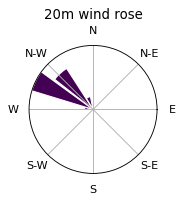

In [510]:
from windrose import WindroseAxes
src = tidy_df[tidy_df.time.isin(downvalley_wind_times)][
    tidy_df.variable.isin(['spd_20m_c', 'dir_20m_c'])
].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()
ax = WindroseAxes.from_ax(figsize=(2,2))
ax.bar(src['wind direction'], src['wind speed'], normed=True, opening=.9, edgecolor='white', bins=1, nsector=17)
ax.set_yticks([])
# ax.set_yticklabels(['10%','25%'])
plt.title("20m wind rose")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_54981/1302002679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = tidy_df[tidy_df.time.isin(upvalley_wind_times)][


Text(0.5, 1.0, '20m wind rose')

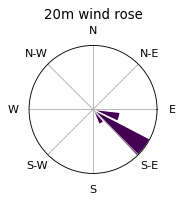

In [511]:
from windrose import WindroseAxes
src = tidy_df[tidy_df.time.isin(upvalley_wind_times)][
    tidy_df.variable.isin(['spd_20m_c', 'dir_20m_c'])
].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()
ax = WindroseAxes.from_ax(figsize=(2,2))
ax.bar(src['wind direction'], src['wind speed'], normed=True, opening=.9, edgecolor='white', bins=1, nsector=17)
ax.set_yticks([])
# ax.set_yticklabels(['10%','25%'])
plt.title("20m wind rose")

### December Blowing Snow Case Study

In [514]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20221221 1200': '20221223 0000'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_turb_flux_divergence_3to10',
        'vertical_turb_flux_divergence_2to10',
        'vertical_turb_flux_divergence_2to20',
        'ds/dt',
        'vertical_advection_numerical_2',
        'vertical_advection_numerical_3',
        'vertical_advection_numerical_5',
        'vertical_advection_numerical_10',
        'vertical_advection_numerical_15',
        'vertical_advection_numerical_20',
    ]].reset_index()

vertical_advection_vars = [
    'vertical_advection_numerical_3', 'vertical_advection_numerical_5',
    'vertical_advection_numerical_10', 'vertical_advection_numerical_15', 'vertical_advection_numerical_20',
]
residual_vars = [
    'residual_3', 'residual_5', 'residual_10', 'residual_15', 'residual_20'
]
w_q_variables = [
    'w_h2o__3m_c_raw',  'w_h2o__5m_c_raw', 'w_h2o__10m_c_raw', 'w_h2o__15m_c_raw','w_h2o__20m_c_raw'
]

vertical_advection_df = src.dropna()[
        ['time'] + vertical_advection_vars
    ].set_index('time').rolling(
        window=5, center=True, min_periods=0
    ).mean().reset_index()


lines_chart_1 = alt.Chart(
    vertical_advection_df
).transform_fold(
    vertical_advection_vars
).mark_line().encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Water vapor flux density', '(g/m^3/s)']),
    alt.Color('key:N').scale(scheme='turbo').sort(vertical_advection_vars)
).properties(width=150, height=150)

other_terms_df = src.dropna()[
        ['time'] + ['vertical_turb_flux_divergence_3to10', 'ds/dt']
    ].set_index('time').rolling(
        window=5, center=True, min_periods=0
    ).mean().reset_index()

lines_chart_2 = alt.Chart(
    other_terms_df
).transform_fold(
    ['vertical_turb_flux_divergence_3to10', 'ds/dt']
).mark_line(color='black').encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Water vapor flux density', '(g/m^3/s)']).scale(
        # domain = [-0.002, 0.004], clamp=True
    ),
    alt.StrokeDash('key:N').scale(
        domain = ['vertical_turb_flux_divergence_3to10', 'ds/dt'],
        range=[(4,2), (1.5,1.5)]
    ),
).properties(width=150, height=150)



bs_chart = alt.Chart(
    tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20221221 1200': '20221223 0000'].reset_index()
).mark_line(color='black').encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
    alt.StrokeDash('height:N', legend=None)
).properties(width=150, height=150)


w_q_chart = alt.Chart(
    tidy_df[tidy_df.variable.isin(w_q_variables)
    ].set_index('time').loc['20221221 1200': '20221223 0000'].reset_index().pivot_table(
        index='time',
        columns='variable',
        values='value'
    ).rolling(
        window=5, center=True, min_periods=0
    ).mean().reset_index()
).transform_fold(
    w_q_variables
).mark_line().encode(
    alt.X('time:T'). axis().title(None),
    alt.Y('value:Q').title(["w'q' (g/m^2/s)"]),
    alt.Color('key:O').scale(scheme='turbo', domain=w_q_variables)
).properties(width=150, height=150)

residuals_df = other_terms_df.merge(
    vertical_advection_df, on='time'
)

residuals_df['residual_3'] = residuals_df['vertical_turb_flux_divergence_3to10'] + residuals_df['ds/dt'] + residuals_df['vertical_advection_numerical_3']
residuals_df['residual_5'] = residuals_df['vertical_turb_flux_divergence_3to10'] + residuals_df['ds/dt'] + residuals_df['vertical_advection_numerical_5']
residuals_df['residual_10'] = residuals_df['vertical_turb_flux_divergence_3to10'] + residuals_df['ds/dt'] + residuals_df['vertical_advection_numerical_10']
residuals_df['residual_15'] = residuals_df['vertical_turb_flux_divergence_3to10'] + residuals_df['ds/dt'] + residuals_df['vertical_advection_numerical_15']
residuals_df['residual_20'] = residuals_df['vertical_turb_flux_divergence_3to10'] + residuals_df['ds/dt'] + residuals_df['vertical_advection_numerical_20']

residuals_chart = alt.Chart(
    residuals_df
).transform_fold(
    residual_vars
).mark_area(color='grey', opacity=0.4).encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('min(value):Q').title(['Water vapor flux density', '(g/m^3/s)']),
    alt.Y2('max(value):Q').title(['Water vapor flux density', '(g/m^3/s)']),
).properties(width=150, height=150)


(
    bs_chart.properties(width=150, height = 150)
    |
    w_q_chart.properties(width=150, height = 150)
    |
    (residuals_chart + lines_chart_1 + lines_chart_2
    ).resolve_scale()
).resolve_scale(
    x='shared', color='independent', strokeDash='independent'
).display(renderer='svg')

alt.HConcatChart(...)

### May 5th Case Study, horizontal advection

In [515]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20230505'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_turb_flux_divergence_3to10',
        'vertical_turb_flux_divergence_3to20',
        'vertical_turb_flux_divergence_2to10',
        'vertical_turb_flux_divergence_2to20',
        'ds/dt',
        # 'vertical_advection_numerical_2',
        'vertical_advection_numerical_3',
        'vertical_advection_numerical_5',
        'vertical_advection_numerical_10',
        'vertical_advection_numerical_15',
        'vertical_advection_numerical_20',
    ]].reset_index()

vertical_advection_vars = [
    'vertical_advection_numerical_3', 'vertical_advection_numerical_5',
    'vertical_advection_numerical_10', 'vertical_advection_numerical_15', 'vertical_advection_numerical_20',
]
residual_vars = [
    'residual_3', 'residual_5', 'residual_10', 'residual_15', 'residual_20'
]
w_q_variables = [
    'w_h2o__3m_c_raw',  'w_h2o__5m_c_raw', 'w_h2o__10m_c_raw', 'w_h2o__15m_c_raw','w_h2o__20m_c_raw'
]

vertical_advection_df = src.dropna()[
        ['time'] + vertical_advection_vars
    ].set_index('time').rolling(
        window=5, center=True, min_periods=0
    ).mean().reset_index()


lines_chart_1 = alt.Chart(
    vertical_advection_df
).transform_fold(
    vertical_advection_vars
).mark_line().encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Water vapor flux density', '(g/m^3/s)']),
    alt.Color('key:N').scale(scheme='turbo').sort(vertical_advection_vars)
).properties(width=150, height=150)

other_terms_df = src.dropna()[
        ['time'] + ['vertical_turb_flux_divergence_3to20', 'ds/dt']
    ].set_index('time').rolling(
        window=5, center=True, min_periods=0
    ).mean().reset_index()

lines_chart_2 = alt.Chart(
    other_terms_df
).transform_fold(
    ['vertical_turb_flux_divergence_3to20', 'ds/dt']
).mark_line(color='black').encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Water vapor flux density', '(g/m^3/s)']).scale(
        # domain = [-0.002, 0.004], clamp=True
    ),
    alt.StrokeDash('key:N').scale(
        domain = ['vertical_turb_flux_divergence_3to20', 'ds/dt'],
        range=[(4,2), (1.5,1.5)]
    ),
).properties(width=150, height=150)

w_q_chart = alt.Chart(
    tidy_df[tidy_df.variable.isin(w_q_variables)
    ].set_index('time').loc['20230505'].reset_index().pivot_table(
        index='time',
        columns='variable',
        values='value'
    ).rolling(
        window=5, center=True, min_periods=0
    ).mean().reset_index()
).transform_fold(
    w_q_variables
).mark_line().encode(
    alt.X('time:T'). axis().title(None),
    alt.Y('value:Q').title(["w'q' (g/m^2/s)"]),
    alt.Color('key:O').scale(scheme='turbo', domain=w_q_variables)
).properties(width=150, height=150)

residuals_df = other_terms_df.merge(
    vertical_advection_df, on='time'
)

residuals_df['residual_3'] = residuals_df['vertical_turb_flux_divergence_3to20'] + residuals_df['ds/dt'] + residuals_df['vertical_advection_numerical_3']
residuals_df['residual_5'] = residuals_df['vertical_turb_flux_divergence_3to20'] + residuals_df['ds/dt'] + residuals_df['vertical_advection_numerical_5']
residuals_df['residual_10'] = residuals_df['vertical_turb_flux_divergence_3to20'] + residuals_df['ds/dt'] + residuals_df['vertical_advection_numerical_10']
residuals_df['residual_15'] = residuals_df['vertical_turb_flux_divergence_3to20'] + residuals_df['ds/dt'] + residuals_df['vertical_advection_numerical_15']
residuals_df['residual_20'] = residuals_df['vertical_turb_flux_divergence_3to20'] + residuals_df['ds/dt'] + residuals_df['vertical_advection_numerical_20']

residuals_chart = alt.Chart(
    residuals_df
).transform_fold(
    residual_vars
).mark_area(color='grey', opacity=0.4).encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('min(value):Q').title(['Water vapor flux density', '(g/m^3/s)']),
    alt.Y2('max(value):Q').title(['Water vapor flux density', '(g/m^3/s)']),
).properties(width=150, height=150)

(
    w_q_chart.properties(width=150, height = 150)
    |
    (
        residuals_chart + lines_chart_1 + lines_chart_2).resolve_scale()
).resolve_scale(
    x='shared', color='independent', strokeDash='independent'
).display(renderer='svg')

alt.HConcatChart(...)

# Solutions for advection corrections

## Linearly interpolate w everywhere

In [ ]:
interp_w_values = []
for datetime, data in vertical_advection_estimates.reset_index().groupby('time'):
    data = data.sort_values('height')
    data['w'] = data['w'].interpolate().values
    interp_w_values.append(data[['time', 'w', 'height']])
interp_w_values = pd.concat(interp_w_values).set_index('time')

In [ ]:
vertical_advection_estimates_updated_w = vertical_advection_estimates.reset_index().set_index(['time', 'height']).drop(columns='w').join(
    interp_w_values.reset_index().set_index(['time', 'height'])
)

In [ ]:
plt.scatter(
    vertical_advection_estimates.loc['20230505 1200']['w'],
    vertical_advection_estimates.loc['20230505 1200']['height'],
)

plt.scatter(
    vertical_advection_estimates_updated_w.loc['20230505 1200'].reset_index()['w'],
    vertical_advection_estimates_updated_w.loc['20230505 1200'].reset_index()['height'],
    s=2
)
plt.xlabel('w (m/s)')
plt.ylabel('z (m)')

## Solve the integral numerically

$$ \overline{w'\rho_v'}_{0} = \overline{w'\rho_v'}_{H} + \int_0^H \overline{w} \rho \frac{d \sigma}{d z} dz$$

Calculate the above integral for each time step. At each time step, linearly interpolate measurements of $\overline{w}$, assuming a no-slip condition, as we have measurements of $\rho$ and estimates of $d\sigma / dz$ every meter. This allows us to solve the integral between 0 and $H$ at any of the eddy covariance heights, using a trapezoidal approach.

Note that:
* H for each EC changes with time due to snow depth
* $\frac{d \sigma}{dz}$ is estimated using log polynomial, while $\overline{w}$ is estimated using linear interpolation

In [ ]:
snowdepth_data = tidy_df.query("variable == 'SnowDepth_c'").set_index('time')['value']
snowdepth_data = round(snowdepth_data, 4)

In [ ]:
vertical_advection_estimates_updated_w = vertical_advection_estimates_updated_w.reset_index().set_index('time')

In [ ]:
corrections = dict()
for datetime in vertical_advection_estimates_updated_w.index.unique():
    one_date_example = vertical_advection_estimates_updated_w.loc[datetime].set_index('height')
    
    # this_snowdepth = snowdepth_data.loc[datetime]
    this_snowdepth = 0

    one_date_example.index = one_date_example.index - this_snowdepth
    one_date_example = one_date_example[one_date_example.index > 0]

    lowest_meas_height = one_date_example.index.min()
    one_date_example.loc[0, 'w'] = 0
    one_date_example.loc[0, 'rho_d'] = one_date_example.loc[lowest_meas_height, 'rho_d']
    one_date_example.loc[0, 'dsigma_dz'] = one_date_example.loc[lowest_meas_height, 'dsigma_dz']

    one_date_example['vertical_advection'] = one_date_example['w'] * one_date_example['rho_d'] * one_date_example['dsigma_dz'] * 1000

    one_date_example = one_date_example.sort_index()
    
    vert_adv_correction_2m = np.trapz(
        one_date_example['vertical_advection'].loc[ : (2 - this_snowdepth)],
        one_date_example['vertical_advection'].loc[ : (2 - this_snowdepth)].index
    )
    vert_adv_correction_3m = np.trapz(
        one_date_example['vertical_advection'].loc[ : (3 - this_snowdepth)],
        one_date_example['vertical_advection'].loc[ : (3 - this_snowdepth)].index
    )
    vert_adv_correction_5m = np.trapz(
        one_date_example['vertical_advection'].loc[ : (5 - this_snowdepth)],
        one_date_example['vertical_advection'].loc[ : (5 - this_snowdepth)].index
    )
    vert_adv_correction_10m = np.trapz(
        one_date_example['vertical_advection'].loc[ : (10 - this_snowdepth)],
        one_date_example['vertical_advection'].loc[ : (10 - this_snowdepth)].index
    )
    vert_adv_correction_15m = np.trapz(
        one_date_example['vertical_advection'].loc[ : (15 - this_snowdepth)],
        one_date_example['vertical_advection'].loc[ : (15 - this_snowdepth)].index
    )
    vert_adv_correction_20m = np.trapz(
        one_date_example['vertical_advection'].loc[ : (20 - this_snowdepth)],
        one_date_example['vertical_advection'].loc[ : (20 - this_snowdepth)].index
    )
    corrections[datetime] = {
        2: vert_adv_correction_2m,
        3: vert_adv_correction_3m,
        5: vert_adv_correction_5m,
        10: vert_adv_correction_10m,
        15: vert_adv_correction_15m,
        20: vert_adv_correction_20m
    }
    

## Aggregate results

Aggregate vertical advection correction estimates

In [ ]:
corrections_df = pd.DataFrame(corrections).T.melt(ignore_index=False).rename(columns={
    'variable': 'height',
    'value': 'vertical_advection_correction'
})
corrections_df.index = corrections_df.index.rename('time')
corrections_df = corrections_df.reset_index().set_index(['time', 'height'])
corrections_df

Combine with gapfilled EC flux measurements

In [ ]:
sublimation_gapfilled = tidy_df.query("measurement == 'w_h2o_'").query("tower == 'c'").query("height > 1")
sublimation_gapfilled = sublimation_gapfilled[sublimation_gapfilled.variable.str.contains('gapfill')].set_index(['time', 'height'])
sublimation_gapfilled = sublimation_gapfilled.join(corrections_df)
sublimation_gapfilled = sublimation_gapfilled.rename(columns={'value': 'w_h2o__'})
sublimation_gapfilled['vertical_advection_correction'] = sublimation_gapfilled['vertical_advection_correction'].fillna(0)
sublimation_gapfilled['w_h2o__corrected'] = sublimation_gapfilled['w_h2o__'] + sublimation_gapfilled['vertical_advection_correction']
sublimation_gapfilled

In [ ]:
from metpy.constants import density_water
seconds_in_timestep = 60*30
sublimation_gapfilled_mm = sublimation_gapfilled[['w_h2o__', 'w_h2o__corrected']]
sublimation_gapfilled_mm = sublimation_gapfilled_mm*seconds_in_timestep/density_water.magnitude

In [ ]:
sublimation_gapfilled_cumsum = sublimation_gapfilled_mm.groupby(level=[1]).apply(lambda df: df.cumsum())
sublimation_gapfilled_cumsum.index = sublimation_gapfilled_cumsum.index.droplevel(0)
sublimation_gapfilled_cumsum_daily = sublimation_gapfilled_cumsum.reset_index().set_index('time').groupby([
    pd.Grouper(freq='1440min'), 'height'
]).max().reset_index()

In [ ]:
alt.Chart(
    sublimation_gapfilled_cumsum_daily
).transform_filter(
    alt.FieldOneOfPredicate('height', [3,5,10,20])
).transform_fold(
    ['w_h2o__',	'w_h2o__corrected']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.StrokeDash('key:N'),
    alt.Color('height:O').scale(scheme='turbo')
).properties(width=400, height=300)

In [ ]:


alt.Chart(
    sublimation_gapfilled_cumsum.loc['20230508 2330', :].reset_index()
).transform_fold([
    'w_h2o__', 'w_h2o__corrected'
]).mark_point(size=100).encode(
    alt.Y("height:O").sort('-y').title("Height (m)"),
    alt.X("value:Q").scale(zero=False).title(["Total sublimation (mm)"]),
    alt.Shape("key:N")
).properties(width = 150, height = 150)

In [ ]:
round(sublimation_gapfilled_cumsum.loc['2023-05-08 23:30:00'], 1)

In [ ]:
import seaborn as sns

In [ ]:
src = ((sublimation_gapfilled['w_h2o__corrected'] - sublimation_gapfilled['w_h2o__']) / sublimation_gapfilled['w_h2o__'])
print(len(src))
src = src[src < 1]
print(len(src))
src = src[src > -1]
print(len(src))

In [ ]:
sns.distplot(
    src
)

In [ ]:
display(((sublimation_gapfilled['w_h2o__corrected'] - sublimation_gapfilled['w_h2o__']) / sublimation_gapfilled['w_h2o__']).quantile(0.25))
display(((sublimation_gapfilled['w_h2o__corrected'] - sublimation_gapfilled['w_h2o__']) / sublimation_gapfilled['w_h2o__']).quantile(0.50))
display(((sublimation_gapfilled['w_h2o__corrected'] - sublimation_gapfilled['w_h2o__']) / sublimation_gapfilled['w_h2o__']).quantile(0.75))

In [ ]:
round(sublimation_gapfilled_cumsum.loc['2023-05-08 23:30:00']['w_h2o__corrected'] / sublimation_gapfilled_cumsum.loc['2023-05-08 23:30:00']['w_h2o__'] - 1, 3)

In [ ]:
round(sublimation_gapfilled_cumsum.loc['2023-05-08 23:30:00']['w_h2o__corrected'] / sublimation_gapfilled_cumsum.loc['2023-05-08 23:30:00']['w_h2o__'] - 1, 3).mean()

In [ ]:
alt.Chart(
    sublimation_gapfilled_cumsum.reset_index()
).transform_fold([
    'w_h2o__', 'w_h2o__corrected'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('value:Q'),
    alt.StrokeDash('key:N'),
    alt.Facet('height:O')
)